In [1]:
import numpy as np
import xarray
import datetime
import matplotlib.pyplot as plt

Data was downloaded from:

https://data.ozflux.org.au/portal/pub/listPubCollections.jspx


In [2]:
station = 'Samford'
#station = 'Longreach'

#fname = '/g/data/w40/clv563/ozflux_data/'+station+'*.nc'

fname = '/g/data/w40/clv563/ozflux_data/Samford_2022_L3.nc'

In [3]:
# Time period we are looking at:
tstart = datetime.datetime(2022,2,22)
tend = datetime.datetime(2022,3,8)

### Variable names in the oxflux data sets are usually:

Fe - latent heat flux
Fh or Fh_PFP - sensible heat flux

These may vary slighly aross different sites -> need to automate code to accept different variable names if looping over all sites is required.

### Variable names in AUS2200 files

hfss - sensible heat flux at the surface
hfls - latent heat flux at the surface

In [4]:
ds = xarray.open_dataset(fname)

latent_hfx_obs = ds.Fe
#sensible_hfx_obs = ds.Fh_PFP
sensible_hfx_obs = ds.Fh

air_temperature_obs = ds.Ta

In [5]:
air_temperature_obs

<xarray.DataArray 'Ta' (time: 6296, latitude: 1, longitude: 1)>
[6296 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-05-12T03:30:00
  * latitude   (latitude) float64 -27.39
  * longitude  (longitude) float64 152.9
Attributes:
    coverage_L2:       99%
    coverage_L3:       99%
    description_L3:    Merged from Ta_HMP_4m, Ta_IRGA_4m, Ta_SONIC_Av
    height:            3.75m
    instrument:        Vaisala HMP155
    long_name:         Air temperature
    rangecheck_lower:  -10
    rangecheck_upper:  50
    standard_name:     air_temperature
    statistic_type:    average
    units:             degC
    valid_range:       [-10.  50.]

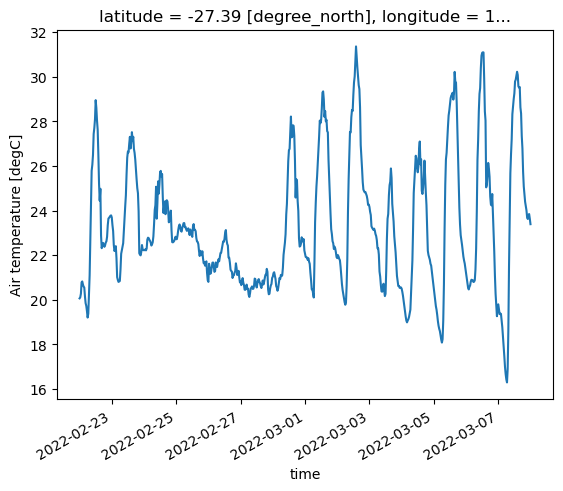

In [6]:
latent_hfx_obs_timeselect = latent_hfx_obs.sel(time=slice(tstart, tend))
sensible_hfx_obs_timeselect = sensible_hfx_obs.sel(time=slice(tstart, tend))
air_temperature_obs_timeselect = air_temperature_obs.sel(time=slice(tstart,tend))

latent_hfx_obs_timeselect = np.squeeze(latent_hfx_obs_timeselect[:,0,0])
sensible_hfx_obs_timeselect = np.squeeze(sensible_hfx_obs_timeselect[:,0,0])
air_temperature_obs_timeselect = np.squeeze(air_temperature_obs_timeselect[:,0,0])

# Missing data is coded as -9999. Replace with Nans
latent_hfx_obs_timeselect[np.array(latent_hfx_obs_timeselect < -100)] = np.nan
sensible_hfx_obs_timeselect[np.array(sensible_hfx_obs_timeselect < -100)] = np.nan

air_temperature_obs_timeselect.plot()


In [7]:
## Now extract nearest gridpoint sfc and latent heat flux from AUS2200

# Find the station longitude and latitude
station_longitude = ds.longitude
station_latitude = ds.latitude

print(station_longitude, station_latitude)

<xarray.DataArray 'longitude' (longitude: 1)>
array([152.872611])
Coordinates:
  * longitude  (longitude) float64 152.9
Attributes:
    long_name:      longitude
    standard_name:  longitude
    units:          degree_east <xarray.DataArray 'latitude' (latitude: 1)>
array([-27.387688])
Coordinates:
  * latitude  (latitude) float64 -27.39
Attributes:
    long_name:      latitude
    standard_name:  latitude
    units:          degree_north


In [8]:
# Aus2200 filename

sen_hf_fname = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/surf/1hr/hfss_1hr_20220222_20220307.nc'
lat_hf_fname = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/surf/1hr/hfls_1hr_20220222_20220307.nc'
temp2m_fname = '/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/data/surf/1hr/tas_1hr_20220222_20220307.nc'


In [9]:
# Select the nearest neighbour to the station
ds = xarray.open_dataset(sen_hf_fname)
station_ds_sen = ds.sel(latitude=station_latitude, longitude=station_longitude, method="nearest")

ds = xarray.open_dataset(lat_hf_fname)
station_ds_lat = ds.sel(latitude=station_latitude, longitude=station_longitude, method="nearest")

ds = xarray.open_dataset(temp2m_fname)
station_ds_t2m = ds.sel(latitude=station_latitude, longitude=station_longitude, method="nearest")

In [10]:
# Station obs are in local time
# Stamford and Longreach are in QLD - no daylight savings -> UTC + 10
## Fix this to check local time based on lat lon

station_time_local = sensible_hfx_obs_timeselect.time

#station_time_local
station_time_UTC = station_time_local - np.timedelta64(10,'h')

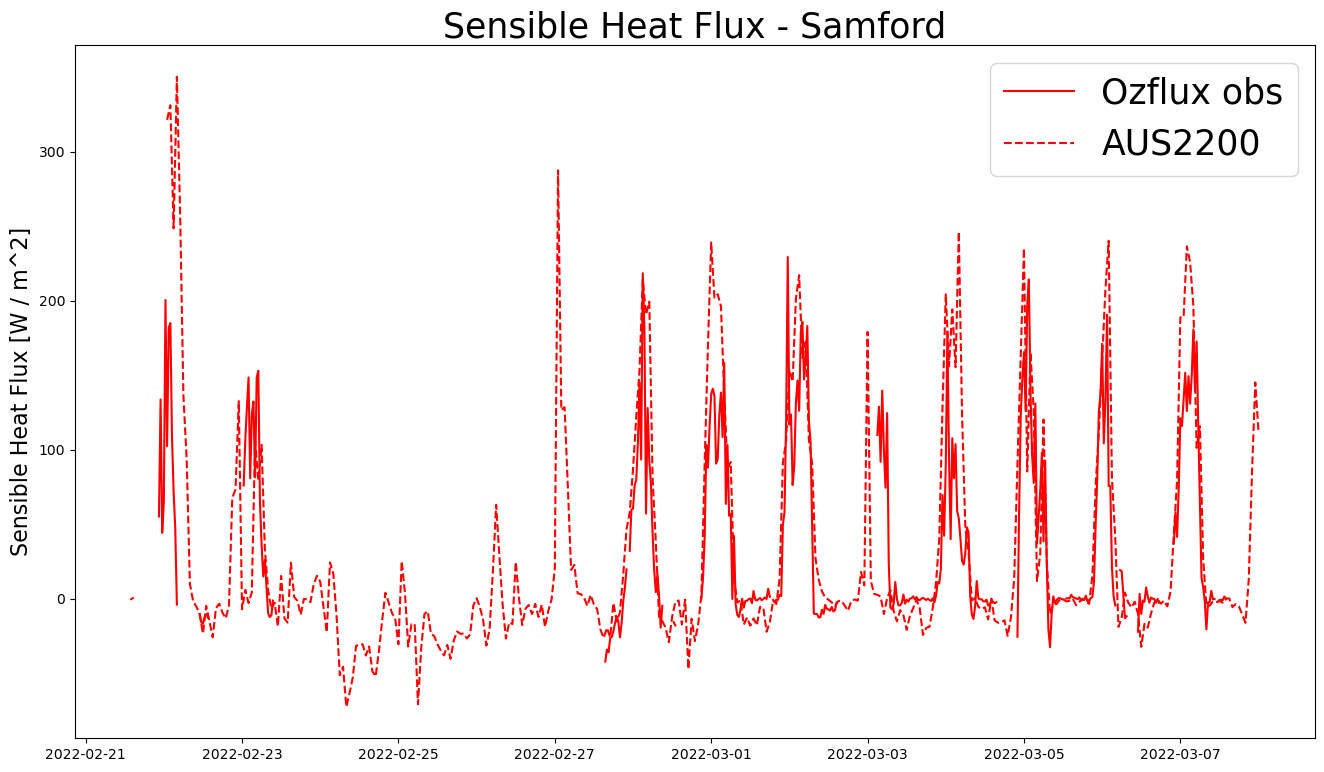

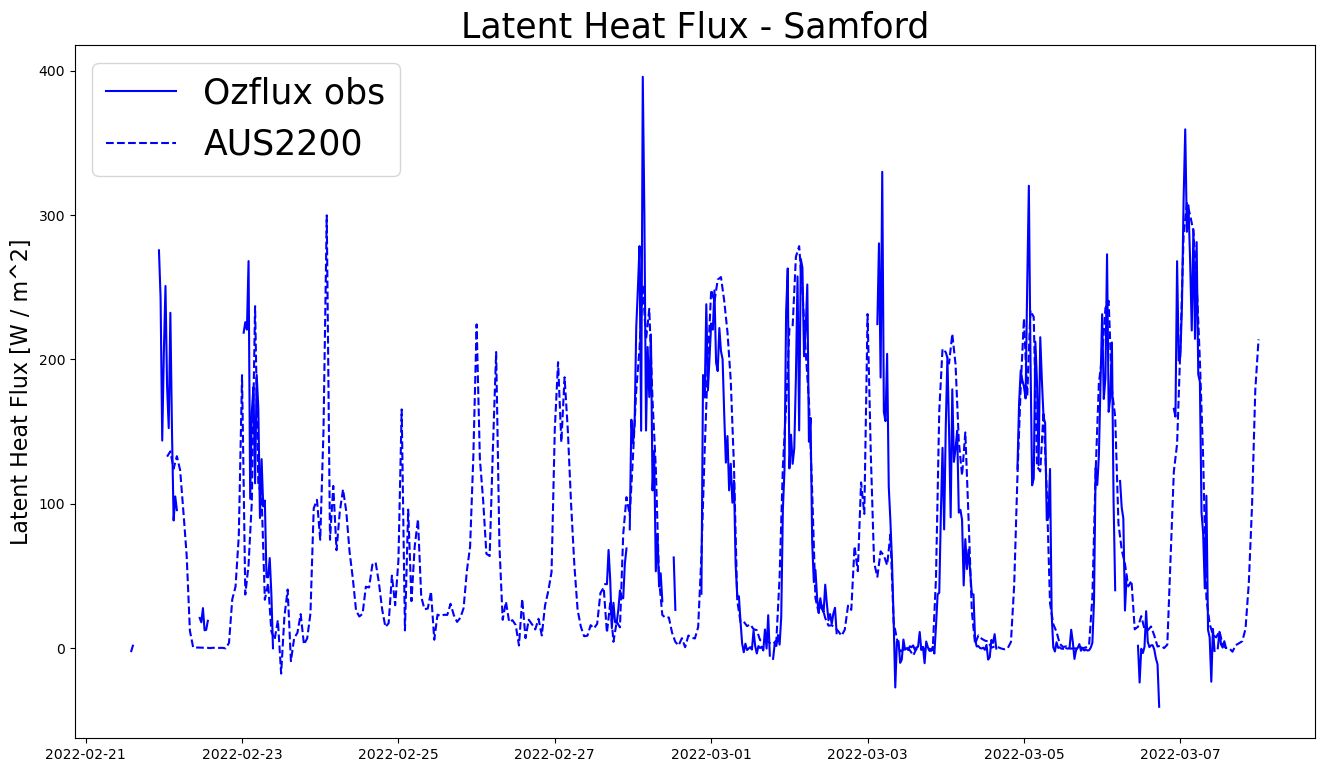

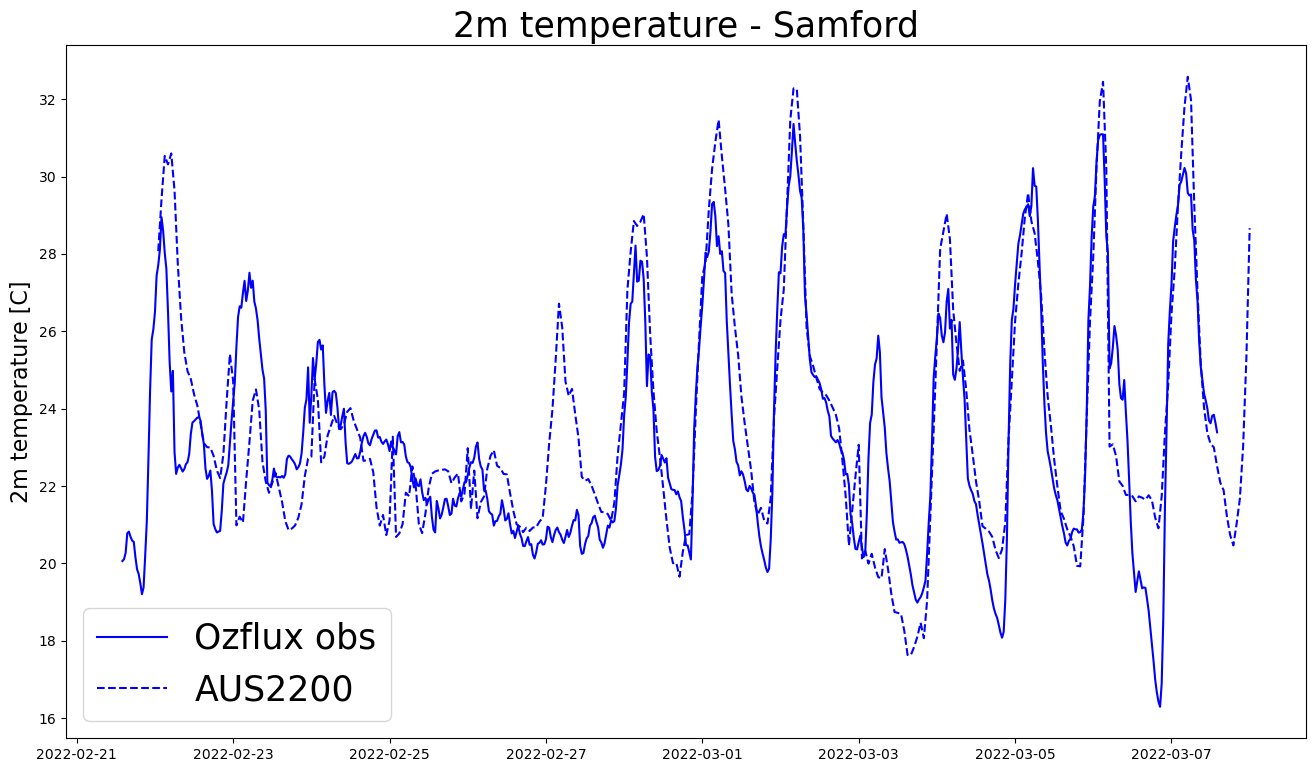

In [11]:
# Make a plot - Sensible heat flux
fig = plt.figure(1, figsize=(16., 9.))
ax = plt.axes()


plt.plot(station_time_UTC, sensible_hfx_obs_timeselect,color='r', label='Ozflux obs')
plt.plot(station_ds_sen.time, np.squeeze(station_ds_sen.hfss), color='r', linestyle='--', label='AUS2200')
plt.title('Sensible Heat Flux - '+station, fontsize=25)
plt.ylabel('Sensible Heat Flux [W / m^2]', fontsize=16)
ax.legend(fontsize=25)
plt.savefig('/home/563/clv563/AUS2200_validation/AUS2200_CLEX_analysis/evaluation/surface_radiation/sensible_HF_'+station)

# Make a plot - latent heat flux
fig = plt.figure(2, figsize=(16., 9.))
ax = plt.axes()

plt.plot(station_time_UTC, latent_hfx_obs_timeselect,color='b', label='Ozflux obs')
plt.plot(station_ds_sen.time, np.squeeze(station_ds_lat.hfls), color='b', linestyle='--', label='AUS2200')
plt.title('Latent Heat Flux - '+station, fontsize=25)
plt.ylabel('Latent Heat Flux [W / m^2]', fontsize=16)
ax.legend(fontsize=25)
plt.savefig('/home/563/clv563/AUS2200_validation/AUS2200_CLEX_analysis/evaluation/surface_radiation/latent_HF_'+station)

# Make a plot - 2m temperature
fig = plt.figure(3, figsize=(16., 9.))
ax = plt.axes()

plt.plot(station_time_UTC, air_temperature_obs_timeselect,color='b', label='Ozflux obs')
plt.plot(station_ds_sen.time, np.squeeze(station_ds_t2m.tas) - 273.15, color='b', linestyle='--', label='AUS2200')
plt.title('2m temperature - '+station, fontsize=25)
plt.ylabel('2m temperature [C]', fontsize=16)
ax.legend(fontsize=25)
plt.savefig('/home/563/clv563/AUS2200_validation/AUS2200_CLEX_analysis/evaluation/surface_radiation/temp2m_'+station)